# The User Interface of our robot 

In [1]:
from ipywidgets import VBox,HBox
import ipywidgets as widgets
import jupyros as jr
import rospy
from IPython.display import display, clear_output
import time
import numpy as np

from assignement_3.msg import User
from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan 

## Declaration of publishers

In [2]:
mode_publisher = rospy.Publisher('user_topic', User, queue_size=10)
velocity_publisher = rospy.Publisher('cmd_vel',Twist, queue_size=10) 
rospy.init_node('user_interface', anonymous=True)

inputt=User()
velocity=Twist()


## Callback function of LaserScan to get the distance of the obstacles

In [3]:
#min1=[]
#min2=[]
#min3=[]

def odom_callback(msg):
  global min1,min2,min3
  min1=msg.ranges[300]
  min2=msg.ranges[660] #left
  min3=msg.ranges[0]

jr.subscribe('/scan', LaserScan, odom_callback)
dist_button = widgets.Button(description="Nearset obstacle!", button_style='' 'success' '')
dist_output = widgets.Output(layout={'border': '1px solid black'})

def on_button_distance(b):
    distFront=min1
    distLeft =min2
    distRight=min3
    with dist_output:
            clear_output()
            if distFront>distLeft and distFront>distRight:
                print('The nearest obstacle is on the  FRONT with \n        ')
                print('a distance =  ',distFront)
            if distLeft>distFront and distLeft>distRight:
                print('The nearest obstacle is on the LEFT with  \n        ')
                print('a distance = ',distLeft)
            if distRight>distFront and distRight>distLeft:    
                print('The nearest obstacle is on the RIGHT with  \n    ')
                print('a distance = ',distRight)

dist_button.on_click(on_button_distance)

## Widgets 

In [4]:
x_axis=widgets.BoundedFloatText(value=1.0,min=-20.0,max=20.0, step=0.1,description='x_axix:',disabled=False)
y_axis=widgets.BoundedFloatText(value=1.0,min=-20.0,max=20.0, step=0.1,description='y_axix:',disabled=False)

forward = widgets.Button(description="Forward", button_style='' 'info' '')
backward = widgets.Button(description="Backward", button_style='' 'info' '')
left = widgets.Button(description="Left", button_style='' 'info' '')
right = widgets.Button(description="Right", button_style='' 'info' '')

button1 = widgets.Button(description="Mode 1", button_style='' 'danger' '')
button2 = widgets.Button(description="Mode 2", button_style='' 'danger' '')
button3 = widgets.Button(description="Mode 3", button_style='' 'danger' '')
button4 = widgets.Button(description="Cancel the goal", button_style='' 'danger' '')
output = widgets.Output(layout={'border': '1px solid black'})

empty_space= widgets.Output()
with empty_space:
    print("                 ")

## Moving the robot by buttons 

In [5]:
def on_button_clickedF(b):
    if inputt.user==2 or inputt.user==3:
        velocity.linear.x=0.5
        velocity_publisher.publish(velocity)
        time.sleep(1)
        velocity.linear.x=0.0
        velocity_publisher.publish(velocity)
        with output:
            print('Moving Forward')
            
def on_button_clickedB(b):
    if inputt.user==2 or inputt.user==3:
        velocity.linear.x=-0.5
        velocity_publisher.publish(velocity)
        time.sleep(1)
        velocity.linear.x=0.0
        velocity_publisher.publish(velocity)
        with output:
            print('Moving Backword')
            
def on_button_clickedL(b):
    if inputt.user==2 or inputt.user==3:
        velocity.angular.z=1.0
        velocity_publisher.publish(velocity)
        time.sleep(1)
        velocity.angular.z=0.0
        velocity_publisher.publish(velocity)
        with output:
            print('Moving Left')
            
def on_button_clickedR(b):
    if inputt.user==2 or inputt.user==3:
        velocity.angular.z=-1.0
        velocity_publisher.publish(velocity)
        time.sleep(1)
        velocity.angular.z=0.0
        velocity_publisher.publish(velocity)
        with output:
            print('Moving Right')

## Choose the mode of the robot

In [6]:
def on_button_clicked1(b):
        inputt.user=1
        inputt.x=x_axis.value
        inputt.y=y_axis.value
        mode_publisher.publish(inputt)
        with output:
            clear_output()
            print('Mode1, Your goal is x= (',x_axis.value,',',y_axis.value,')')
            
def on_button_clicked2(b):
        
        inputt.user=2
        mode_publisher.publish(inputt)
        with output:
            clear_output()
            print('Mode2,Not assistive drive ')
            
def on_button_clicked3(b):
        inputt.user=3
        mode_publisher.publish(inputt)
        with output:
            clear_output()
            print('Mode3,Assistive drive')

def on_button_clicked4(b):
        inputt.user=4
        mode_publisher.publish(inputt)
        with output:
            clear_output()
            print('Mode4,The goal in canceled')

## Button's events 

In [7]:
button1.on_click(on_button_clicked1)
button2.on_click(on_button_clicked2)
button3.on_click(on_button_clicked3)
button4.on_click(on_button_clicked4)

forward.on_click(on_button_clickedF)
backward.on_click(on_button_clickedB)
left.on_click(on_button_clickedL)
right.on_click(on_button_clickedR)

## Displaying of the widgets

In [8]:
row1=HBox([button1,empty_space,empty_space,empty_space,dist_button])
row2=HBox([x_axis,empty_space,empty_space,dist_output])
row3=HBox([y_axis])
row4=HBox([button2,button3])
row5=HBox([empty_space,empty_space,forward])
row6=HBox([empty_space,left,empty_space,right])
row7=HBox([empty_space,empty_space,backward])
row8=HBox([button4])
row10=HBox([output])
row9=HBox([empty_space])
display(VBox([row1,row2,row3,row9,row4,row9,row5,row6,row7,row9,row8,row9,row10]))

<IPython.core.display.Javascript object>


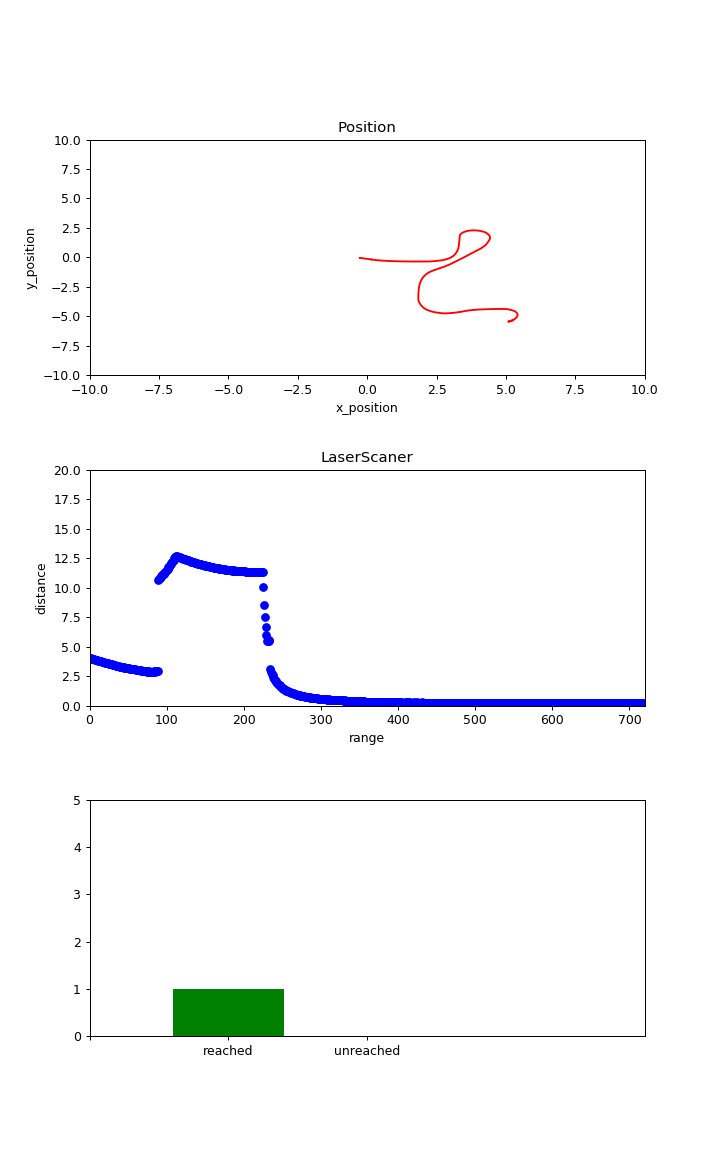

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
from matplotlib.animation import FuncAnimation
from actionlib_msgs.msg import GoalStatusArray

class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots(3, 1,figsize=(8,13))

        self.ln, = self.ax[0].plot([], [], 'r')
        self.x_dist = []
        self.y_dist = [] 
   
  ##
        self.ln2, = self.ax[1].plot([], [], 'bo')
        self.x_data=np.linspace(0, 720, 720)
        self.y_data=[]
  ##
        self.x=[]
        self.y=[]
        self.ln3 = self.ax[2].bar(self.x,self.y)
        self.i=0
        self.j=0
        self.k1=0
        self.k2=0
 
    def plot_init(self):
        self.ax[0].set_xlim(-10, 10)
        self.ax[0].set_ylim(-10, 10)
        self.ax[0].set_title('Position')
        self.ax[0].set_xlabel('x_position')
        self.ax[0].set_ylabel('y_position')
    ##
        self.ax[1].set_xlim(0, 720)
        self.ax[1].set_ylim(0, 20)  
        self.ax[1].set_title('LaserScaner')
        self.ax[1].set_xlabel('range')
        self.ax[1].set_ylabel('distance')
  ##
        self.ax[2].set_xlim(0, 4)
        self.ax[2].set_ylim(0, 5)


        return self.ln,self.ln2,self.ln3


    def odom_callback(self, msg):
        self.y_dist.append(msg.pose.pose.position.y)
        self.x_dist.append(msg.pose.pose.position.x)

    def scan_callback(self, msg):
        self.y_data=msg.ranges  # don't use append:: append adds elements to the list;; so u add 720 each time (nooo)

    def goal_status_callback(self, msg):
         if len(msg.status_list) !=0 :
            if msg.status_list[0].status == 3 and self.k1 == 0:
                self.i = self.i +1
                self.k1 = 1
                self.k2 = 0
    
            elif msg.status_list[0].status == 4 and self.k2 ==0:
                self.j = self.j +1
                self.k2=1
                self.k1 =0
            elif msg.status_list[0].status == 1:
                self.k1 = 0
                self.k2 = 0

                self.y=[self.i,self.j]
                self.x=[" ","reached","unreached"]
                self.y=[0,self.i,self.j]
                self.ln3 = self.ax[2].bar(self.x,self.y,color='green')

    def update_plot(self, frame):
        self.ln.set_data(self.x_dist, self.y_dist)
        self.ln2.set_data(self.x_data, self.y_data)
        #self.ln3.set_data(self.x,self.y)
    
    
        return self.ln,self.ln2,self.ln3

#rospy.init_node('odom_visualizer_node')
vis = Visualiser()
sub2 = rospy.Subscriber('/scan', LaserScan, vis.scan_callback)
sub3 = rospy.Subscriber('/move_base/status', GoalStatusArray, vis.goal_status_callback)

sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.subplots_adjust(hspace=0.4)
plt.show(block=True)